In [3]:
import numpy as np
from astropy.io import fits
import os
import re

from src.hdu.cubes.cube import Cube
from src.hdu.arrays.array_3d import Array3D
from src.headers.header import Header

In [8]:
def translate_id(id: str) -> np.ndarray:
    """ 
    Translates a string id into a vector.
    """
    translation = {
        "N" : np.array([ 0, 1]),
        "S" : np.array([ 0,-1]),
        "E" : np.array([-1, 0]),
        "W" : np.array([ 1, 0])
    }

    # Define the pattern to match letter followed by digits
    pattern = re.compile(r'([A-Z])(\d*)')
    matches = pattern.findall(id)
    result = np.array([0, 0])
    for letter, number in matches:
        if number == "":
            number = 1
        else:
            number = int(number)
        result += translation[letter] * number
    
    return result

def set_region(cube_data: np.ndarray, center: tuple, region: fits.HDUList):
    """
    Sets a region of a given cube.
    """
    smart_slice = lambda start, length: slice(int(start), int(start+length))
    cube_data[
        :int(region.header["NAXIS3"]),
        smart_slice(center[1]-region.header["CRPIX2"], region.header["NAXIS2"]),
        smart_slice(center[0]-region.header["CRPIX1"], region.header["NAXIS1"])
    ] = region.data

def get_cleaned_header(header: Header) -> Header:
    """
    Filters the given header to remove any invalid keywords.
    """
    valid_cards = []
    valid_keywords = [
        "SIMPLE", "BITPIX", "NAXIS", "NAXIS1", "NAXIS2", "NAXIS3", "BUNIT", "EQUINOX", "CRPIX1", "CRPIX2", "CROTA1",
        "CROTA2", "CRVAL1", "CRVAL2", "CTYPE1", "CTYPE2", "CDELT1", "CDELT2", "CRPIX3", "CROTA3", "CRVAL3", "CTYPE3",
        "CDELT3", "BUNIT", "OBSERVER", "LINE", "EQUINOX", "VELO-LSR"
    ]
    for card in header.cards:
        if card.keyword in valid_keywords:
            valid_cards.append(fits.Card(
                keyword=card.keyword,
                value=card.value,
                comment=card.comment
            ))
    
    return Header(valid_cards)

def build_cube(prefix: str, ref_cube: Cube) -> Cube:
    cube_data = np.full((10000, 200, 200), np.NAN)
    files = os.listdir(f"data/Loop4_co/13co_spectrums/{prefix}")
    
    # Create an arbitrary center
    center = np.array([100, 100])

    first_file = True
    for file in files:
        subregion = fits.open(f"data/Loop4_co/13co_spectrums/{prefix}/{file}")[0]
        subregion_id = file[len(prefix):-5]
        if subregion.header["CTYPE1"] == "RA---GLS" and subregion.header["CTYPE2"] == "DEC--GLS":
            set_region(cube_data, center + translate_id(subregion_id)*3, subregion)
        else:
            raise TypeError
        if first_file:
            cube_header = subregion.header
            CRPIX_offset = - 2 + translate_id(subregion_id)*3
            cube_header["CRPIX1"] += center[0] + CRPIX_offset[0]
            cube_header["CRPIX2"] += center[1] + CRPIX_offset[1]
            first_file = False

    cube_data[cube_data == 0] = np.NAN
    cube = Cube(Array3D(cube_data), get_cleaned_header(cube_header))
    cube.header["OBJECT"] = f"Loop4{prefix}"

    # Crop the cube to the same dimensions
    print(cube.header["CRVAL1"], ref_cube.header.get_coordinate(cube.header["CRVAL1"], 2))
    raise
    cube.save("t.fits")
    x_lower_limit = round(cube.header["CRPIX1"] - ref_cube.header.get_coordinate(cube.header["CRVAL1"], 2)) + 3
    y_lower_limit = round(cube.header["CRPIX2"] - ref_cube.header.get_coordinate(cube.header["CRVAL2"], 1))
    x_upper_limit = round(x_lower_limit + ref_cube.header["NAXIS1"])
    y_upper_limit = round(y_lower_limit + ref_cube.header["NAXIS2"])
    z_upper_limit = round(np.where(np.all(np.isnan(cube.data), axis=(1,2)))[0][0])

    cube = cube[:z_upper_limit, y_lower_limit:y_upper_limit, x_lower_limit:x_upper_limit]

    cube.save(f"{prefix}.fits", overwrite=True)

In [9]:
build_cube("N1", ref_cube=Cube.load("data/Loop4_co/N1/Loop4N1_FinalJS.fits"))
# build_cube("N4", ref_cube=Cube.load("data/Loop4_co/N4/Loop4N4_Conv_Med_FinalJS_wcs.fits"))

125.1275083115 27


RuntimeError: No active exception to reraise

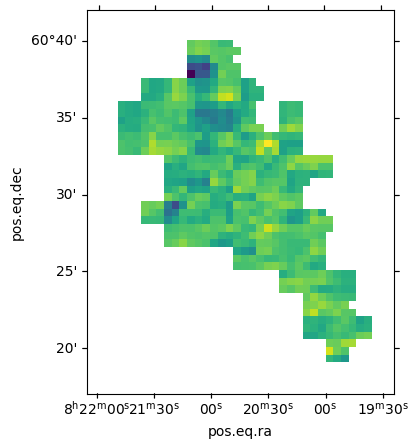

In [14]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes

plot_map = Cube.load("data/Loop4_co/N1/Loop4N1_FinalJS.fits")[0,:,:]
plot_map.save("tt.fits")

fig = plt.figure()
# The axes are set to have celestial coordinates
wcs = WCS(plot_map.header)
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
fig.add_axes(ax)
ax.imshow(plot_map.data, origin="lower")
plt.show()

In [24]:
xx, yy = np.meshgrid(np.arange(3), np.arange(3))
data = xx + 2*yy
header = Header(
    cards=(
    fits.Card("CRPIX1", 1),
    fits.Card("CRPIX2", 1),
    fits.Card("CDELT1", 1),
    fits.Card("CDELT2", 1),
    fits.Card("CRVAL1", 0),
    fits.Card("CRVAL2", 0),
    fits.Card("CTYPE1", "RA---GLS"),
    fits.Card("CTYPE2", "DEC--GLS"),
    )
)
fits.writeto("test_map.fits", data, header, overwrite=True)